# Parameters

In [1]:
import cptdl as dl 
import xcast as xc 
import datetime as dt 
import xarray as xr 
from pathlib import Path 

download_args = { 
  'fdate': dt.datetime(2022, 5, 1),  
  'first_year': 1991, 
  'final_year': 2020, 
  'predictor_extent': {'east': 100, 'west': 60,  'north': 35, 'south': 0}, 
  'predictand_extent': {'east': 100, 'west': 60,  'north': 35, 'south': 0}, 
  'lead_low': 1.5,
  'lead_high': 3.5, 
  'target': 'Jun-Aug',
  'filetype': 'data.nc',
  'ensemblemean': False
}

gcms = [  'CCSM4.PRCP', 'CanSIPSIC3.PRCP']
observations = 'UCSB.PRCP'



# Download Observations

In [2]:
# Download Observations 
if not Path('{}.nc'.format(observations)).is_file():
    print('STARTING DOWNLOAD OF {}'.format(observations))
    Y = dl.download(dl.observations[observations], '{}.tsv'.format(observations), **download_args, verbose=True, use_dlauth=False)
    Y = getattr(Y, [i for i in Y.data_vars][0]).expand_dims({'M':[observations]})
    Y.to_netcdf('{}.nc'.format(observations))
    print()
else:
    Y = xr.open_dataset('{}.nc'.format(observations))
    Y = getattr(Y, [i for i in Y.data_vars][0])

STARTING DOWNLOAD OF UCSB.PRCP
URL: https://iridl.ldeo.columbia.edu/SOURCES/.UCSB/.CHIRPS/.v2p0/.daily-improved/.global/.0p25/.prcp/92/mul/T/(1%20Jan%201991)/(31%20Dec%202020)/RANGE/T/%28Jun-Aug%201991-2020%29/seasonalAverage/Y/%280%29/%2835%29/RANGEEDGES/X/%2860%29/%28100%29/RANGEEDGES/-999/setmissing_value/data.nc

DOWNLOADING: [*************************] (2696 KB) 0:00:00.420623



# Download GCMS

In [3]:
# Download GCMs
models = []
for gcm in gcms:
    if not Path('{}.nc'.format(gcm)).is_file():
        print('STARTING DOWNLOAD OF {}'.format(gcm))
        g = dl.download(dl.hindcasts[gcm], '{}.tsv'.format(gcm), **download_args, verbose=True, use_dlauth=False)
        g = getattr(g, [i for i in g.data_vars][0])
        g.to_netcdf('{}.nc'.format(gcm))
        print()
    else:
        print('LOADING {} FROM FILE'.format(gcm))
        g = xr.open_dataset('{}.nc'.format(gcm), decode_times=False)
        g = getattr(g, [i for i in g.data_vars][0])
        print()
    if 'L' in g.coords:
        g = g.mean('L')
    
    g = xc.regrid(g, Y.coords['X'].values, Y.coords['Y'].values)
    models.append(g)



STARTING DOWNLOAD OF CCSM4.PRCP
URL: https://iridl.ldeo.columbia.edu/SOURCES/.Models/.NMME/.COLA-RSMAS-CCSM4/.MONTHLY/.prec/S/%280000%201%20May%201991-2020%29/VALUES/L/1.5/3.5/RANGEEDGES/%5BL%5D//keepgrids/average/Y/0/35/RANGEEDGES/X/60/100/RANGEEDGES/92/mul/-999/setmissing_value/data.nc

DOWNLOADING: [*************************] (1776 KB) 0:00:00.362942

STARTING DOWNLOAD OF CanSIPSIC3.PRCP
URL: https://iridl.ldeo.columbia.edu/SOURCES/.Models/.NMME/.CanSIPS-IC3/.HINDCAST/.MONTHLY/.prec/S/%280000%201%20May%201991-2020%29/VALUES/L/1.5/3.5/RANGEEDGES/%5BL%5D//keepgrids/average/Y/0/35/RANGEEDGES/X/60/100/RANGEEDGES/92/mul/-999/setmissing_value/data.nc

DOWNLOADING: [*************************] (3551 KB) 0:00:02.297973



# Evaluate Ensemble-Mean Deterministic Forecasts

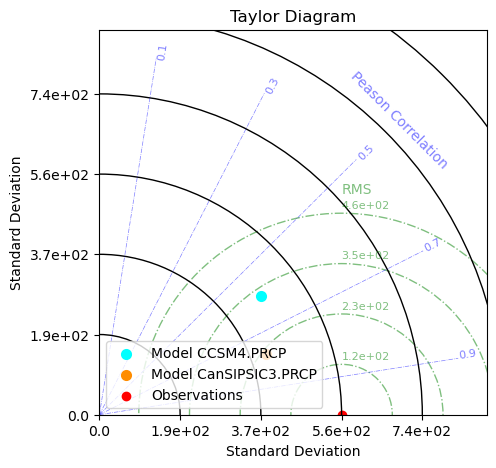

In [20]:
# plot taylor diagram
means = xr.concat([i.mean('M') for i in models], 'M').assign_coords({'M':gcms})
xc.view_taylor(means, Y)

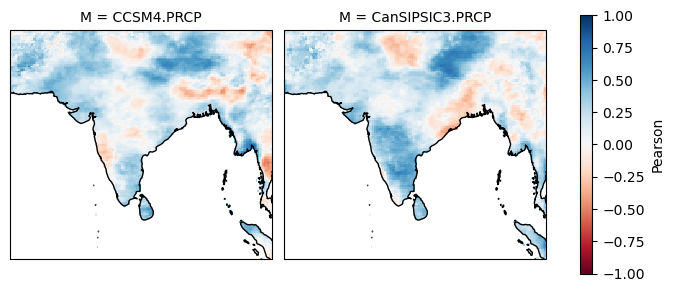

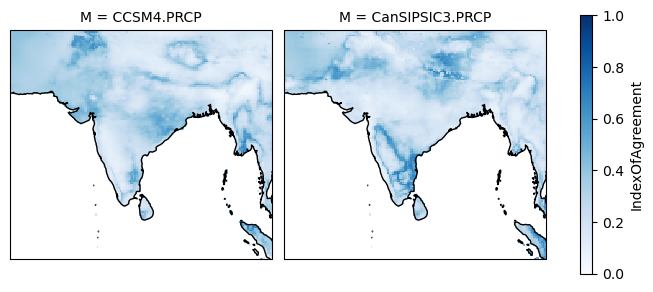

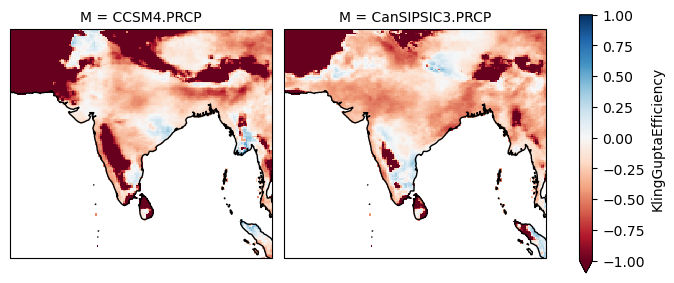

In [14]:
import cartopy.crs as ccrs 

pearsons = []
for model in models: 

    pearson = xc.Pearson(model.mean('M').expand_dims({'M':[0]}), Y)
    pearsons.append(pearson)

pearsons = xr.concat(pearsons, 'M').assign_coords({'M': gcms})

pl = pearsons.plot(col='M', col_wrap=2, cmap='RdBu', vmin=-1, vmax=1, subplot_kws={'projection': ccrs.PlateCarree()})
for ax in pl.axes.flat:
    coasts = ax.coastlines()
    
ioas = []
for model in models: 

    ioa = xc.IndexOfAgreement(model.mean('M').expand_dims({'M':[0]}), Y)
    ioas.append(ioa)

ioas = xr.concat(ioas, 'M').assign_coords({'M': gcms})

pl = ioas.plot(col='M', col_wrap=2, cmap='Blues', vmin=0, vmax=1, subplot_kws={'projection': ccrs.PlateCarree()})
for ax in pl.axes.flat:
    coasts = ax.coastlines()
    
kges = []
for model in models: 

    kge = xc.KlingGuptaEfficiency(model.mean('M').expand_dims({'M':[0]}), Y)
    kges.append(kge)

kges = xr.concat(kges, 'M').assign_coords({'M': gcms})

pl = kges.plot(col='M', col_wrap=2, cmap='RdBu', vmin=-1, vmax=1, subplot_kws={'projection': ccrs.PlateCarree()})
for ax in pl.axes.flat:
    coasts = ax.coastlines() 

# Compute Member-Count Tercile Probabilistic Forecasts

In [9]:
model_member_count = []
for model in models: 
    mc = xc.cMemberCount()
    mc.fit(model, Y)
    prob_model = mc.predict(model)
    model_member_count.append(prob_model)
    


# Evaluate Probabilistic Forecasts 

/Users/kylehall/opt/anaconda3/envs/xcast/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1583: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/Users/kylehall/opt/anaconda3/envs/xcast/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1583: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/Users/kylehall/opt/anaconda3/envs/xcast/lib/python3.9/site-packages/xcast-0.5.7-py3.9.egg/xcast/verification/flat_metrics.py:30: RuntimeWarning: invalid value encountered in double_scalars
/Users/kylehall/opt/anaconda3/envs/xcast/lib/python3.9/site-packages/xcast-0.5.7-py3.9.egg/xcast/verification/flat_metrics.py:26: RuntimeWarning: invalid value encountered in divide
/Users/kylehall/opt/anaconda3/envs/xcast/lib/python3.9/site-packages/xcast-0.5.7-py3.9.egg/xcast/verification/flat_metrics.py:30: RuntimeWarning: invalid value encountered in double_scalars


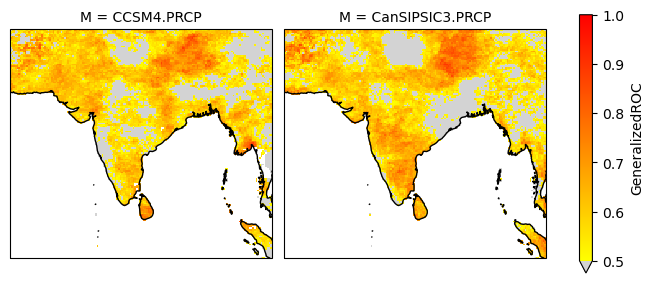

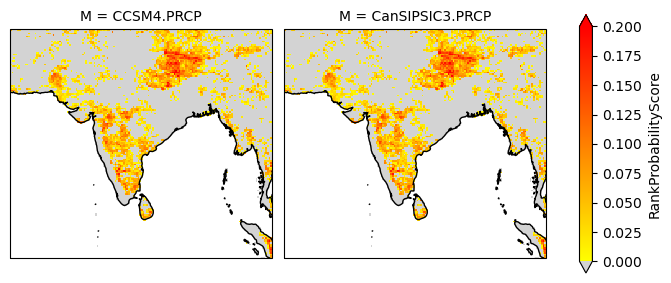

In [19]:
import matplotlib.pyplot as plt 

# compute ground truth terciles 
rt = xc.RankedTerciles() 
rt.fit(Y)
T = rt.transform(Y)

climo_rps = xc.RankProbabilityScore(xr.ones_like(T) * 0.333, T)

cmapg = plt.get_cmap('autumn_r').copy()
cmapg.set_under('lightgray')

grocs = []
for membercount in model_member_count: 

    groc = xc.GeneralizedROC(membercount, T)
    grocs.append(groc)

grocs = xr.concat(grocs, 'M').assign_coords({'M': gcms})

pl = grocs.plot(col='M', col_wrap=len(gcms), cmap=cmapg, vmin=0.5, vmax=1, subplot_kws={'projection': ccrs.PlateCarree()})
for ax in pl.axes.flat:
    coasts = ax.coastlines()
    
rpsss = []
for model in models: 

    rps = xc.RankProbabilityScore(membercount, T)
    rpss = 1 - (rps / climo_rps)
    rpsss.append(rpss)

rpsss = xr.concat(rpsss, 'M').assign_coords({'M': gcms})

cmap = plt.get_cmap('autumn_r').copy()
cmap.set_under('lightgray')

pl = rpsss.plot(col='M', col_wrap=len(gcms), cmap=cmap, vmin=0, vmax=0.2, subplot_kws={'projection': ccrs.PlateCarree()})
for ax in pl.axes.flat:
    coasts = ax.coastlines()
    